In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
!pip install pytorch_pretrained_bert pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [1]:
import pandas as pd

# Load the data!
data = pd.read_csv('/content/drive/MyDrive/MSc Thesis Data Science/influencer_brands/Data/Metadata/all_metadata_5.csv', lineterminator='\n')

Step 1: Turn the captions into a list and pre process captions

In [2]:
# Group by 'post_id' and select the first caption
data = data.groupby('post_id').first().reset_index()

# Convert the captions column to a list
captions = data['caption'].tolist()

In [3]:
# Get posts ID index
post_ids = data['post_id'].tolist()

In [4]:
# Convert all captions to strings, handling NaN values
captions = data['caption'].fillna('').astype(str)

Step 2: Define the tokenizers

In [ ]:
 # Add special tokens at the beginning and end of each sentence for BERT to work properly
#captions = [" [CLS] " + caption + " [SEP]" for caption in captions]

In [5]:
#from transformers import RobertaTokenizer, RobertaModel
#from pytorch_pretrained_bert import BertTokenizer, BertConfig
#from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from transformers import RobertaTokenizer

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base')


tokenized_texts = [tokenizer.tokenize(caption) for caption in captions]


print("Tokenize the first sentence:")
print(tokenized_texts[69])
#
#model = RobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenize the first sentence:
['Your', 'Ġda', 'is', 'ies', 'Ġare', 'Ġnumbered', 'Ġ@', 'v', 'ail', 'mt', 'n', '.', 'ĠWinter', 'Ġis', 'Ġcoming', '.', 'Ġ#', 'p', 'ushing', 'da', 'is', 'ies', 'Ġ#', 'v', 'ail', 'Ġ#', 'v', 'ail', 'mt', 'n', 'Ġ#', 'v', 'ails', 'ummer', 'Ġ#', 'color', 'ado', 'Ġ#', 'mount', 'ain', 'Ġ#', 'fl', 'owers']


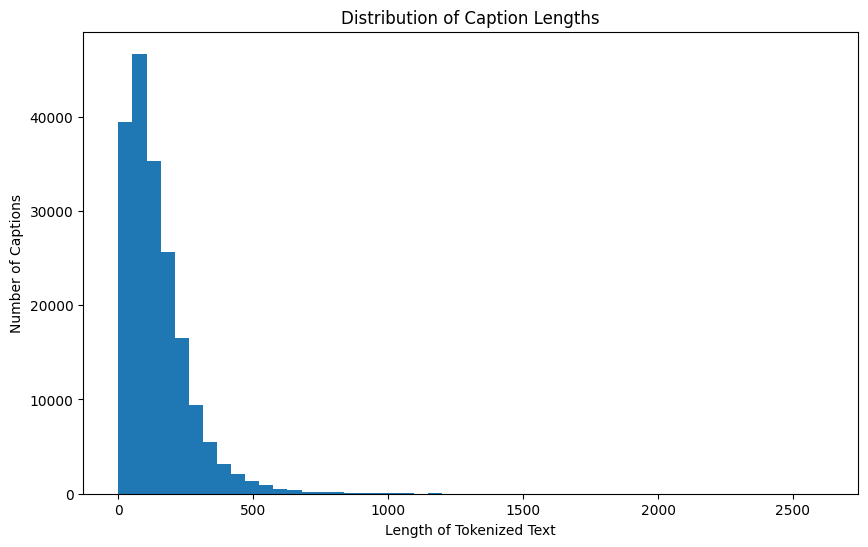

In [6]:
import matplotlib.pyplot as plt

# Calculate the length of each tokenized text
lengths = [len(tokens) for tokens in tokenized_texts]

# Plot a histogram of the lengths
plt.figure(figsize=(10,6))
plt.hist(lengths, bins=50)
plt.title("Distribution of Caption Lengths")
plt.xlabel("Length of Tokenized Text")
plt.ylabel("Number of Captions")
plt.show()

Step 3: Convert Tokens to IDs

Note: I use truncation here but maybe look into alternatives because of loss of data.

In [7]:
# Truncate or pad the tokenized text to a specific length
max_len = 270
input_ids = [tokenizer.convert_tokens_to_ids(x[:max_len]) for x in tokenized_texts]

Step 4: Add Padding

In [8]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 270
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Step 5: Create attention masks for padding and non padding

In [9]:
attention_masks = [[float(i > 0) for i in seq] for seq in input_ids]

In [10]:
# Deletting variables
import gc

# Delete variables you don't need anymore
del max_len, MAX_LEN, tokenized_texts, captions, data, tokenizer

# Run garbage collector
gc.collect()

0

Step 6: Extract features

In [11]:
import torch
from transformers import RobertaModel
import numpy as np
import gc

# Convert to torch tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)

# Load pre-trained model
model = RobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base', output_hidden_states=True)

# Put the model in evaluation mode
model.eval()

# Define batch size
batch_size = 250

# Calculate the number of batches
num_batches = len(input_ids) // batch_size + (0 if len(input_ids) % batch_size == 0 else 1)

# Specify the starting batch number (modify this as needed)
start_from_batch = 529  # Replace 60 with the batch number you want to start from

for batch_num in range(start_from_batch, num_batches):
    start_index = batch_num * batch_size
    end_index = min((batch_num + 1) * batch_size, len(input_ids))
    batch_post_ids = post_ids[start_index:end_index]  # Get corresponding post IDs for the batch

    # Process each batch
    with torch.no_grad():
        outputs = model(input_ids[start_index:end_index], attention_mask=attention_masks[start_index:end_index])
        hidden_states = outputs[2]  # hidden_states is a tuple of 13 elements

        # Use only the last layer's output and calculate mean across all tokens in each caption
        last_layer = hidden_states[-1]
        mean_last_layer = torch.mean(last_layer, dim=1)

        # Convert the mean tensor to a NumPy array and save it for this batch
        np.save(f'/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/text/caption_features_mean_batch_{batch_num}.npy', mean_last_layer.numpy())
        np.save(f'/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/text/post_ids_batch_{batch_num}.npy', np.array(batch_post_ids))

    # Clear memory
    del outputs, hidden_states, last_layer, mean_last_layer
    gc.collect()

KeyboardInterrupt: 

In [ ]:
import torch
#from transformers import BertModel
from transformers import RobertaModel
import numpy as np
import gc

# Convert to torch tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)

# Load pre-trained model
#model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model = RobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base', output_hidden_states=True)

# Put the model in evaluation mode to deactivate dropout layers
model.eval()

# Define batch size
batch_size = 250  # Example batch size

# Calculate the number of batches
num_batches = len(input_ids) // batch_size + (0 if len(input_ids) % batch_size == 0 else 1)

for batch_num in range(num_batches):
    start_index = batch_num * batch_size
    end_index = min((batch_num + 1) * batch_size, len(input_ids))
    batch_post_ids = post_ids[start_index:end_index]  # Get corresponding post IDs for the batch

    # Process each batch
    with torch.no_grad():
        outputs = model(input_ids[start_index:end_index], attention_mask=attention_masks[start_index:end_index])
        hidden_states = outputs[2]  # hidden_states is a tuple of 13 elements

        # Use only the last layer's output and calculate mean across all tokens in each caption
        last_layer = hidden_states[-1]
        mean_last_layer = torch.mean(last_layer, dim=1)

        # Convert the mean tensor to a NumPy array and save it for this batch
        np.save(f'/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/text/caption_features_mean_batch_{batch_num}.npy', mean_last_layer.numpy())
        np.save(f'/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/text/post_ids_batch_{batch_num}.npy', np.array(batch_post_ids))

    # Clear memory
    del outputs, hidden_states, last_layer, mean_last_layer
    gc.collect()

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
import torch
from transformers import BertModel
import numpy as np
import gc

# Convert to torch tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)

# Load pre-trained model
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# Put the model in evaluation mode to deactivate dropout layers
model.eval()

# Define batch size (adjust based on your available memory)
batch_size = 100  # Example batch size

# Calculate the number of batches
num_batches = len(input_ids) // batch_size + (0 if len(input_ids) % batch_size == 0 else 1)

for batch_num in range(num_batches):
    start_index = batch_num * batch_size
    end_index = min((batch_num + 1) * batch_size, len(input_ids))

    # Process each batch
    with torch.no_grad():
        outputs = model(input_ids[start_index:end_index], attention_mask=attention_masks[start_index:end_index])
        hidden_states = outputs[2]  # hidden_states is a tuple of 13 elements

        concatenated_hidden_states = []

        for i in range(len(outputs[0])):
            token_vecs_cat = [torch.cat((hidden_states[-1][i][token],
                                         hidden_states[-2][i][token],
                                         hidden_states[-3][i][token],
                                         hidden_states[-4][i][token]), dim=0)
                              for token in range(len(input_ids[start_index + i]))]
            concatenated_hidden_states.append(token_vecs_cat)

        # Convert the list of concatenated hidden states to a tensor for this batch
        concatenated_hidden_states_tensor = torch.stack([torch.stack(seq) for seq in concatenated_hidden_states])

        # Convert the tensor to a NumPy array and save it for this batch
        np.save(f'/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/text/caption_features_batch_{batch_num}.npy', concatenated_hidden_states_tensor.numpy())

    # Clear memory
    del outputs, hidden_states, concatenated_hidden_states, concatenated_hidden_states_tensor
    gc.collect()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import torch
from transformers import BertModel

# Convert to torch tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)

# Load pre-trained model
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# Put the model in evaluation mode to deactivate dropout layers
model.eval()

# Initialize the list to hold the concatenated hidden states for each token
concatenated_hidden_states = []

# Run the text through BERT, and collect all of the hidden states produced from all 12 layers.
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)
    hidden_states = outputs[2]  # hidden_states is a tuple of 13 elements (1 for the embedding layer and 12 for the transformer layers)

    # Concatenate the last four layers for each token of each sequence
    for i in range(input_ids.size(0)):  # loop over each sequence
        token_vecs_cat = []

        for token in range(input_ids.size(1)):  # loop over each token in the sequence
            # Concatenate the vectors (hidden states) from the last four layers
            # `hidden_states` is a tuple, and we are interested in its last four elements
            cat_vec = torch.cat(
                (hidden_states[-1][i][token],
                 hidden_states[-2][i][token],
                 hidden_states[-3][i][token],
                 hidden_states[-4][i][token]), dim=0)
            token_vecs_cat.append(cat_vec)

        concatenated_hidden_states.append(token_vecs_cat)

# Now `concatenated_hidden_states` is a list where each element is a list of concatenated token vectors for each input sequence

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
import numpy as np

# Convert the list of concatenated hidden states to a tensor
concatenated_hidden_states_tensor = torch.stack([torch.stack(seq) for seq in concatenated_hidden_states])

# Convert the tensor to a NumPy array and save it
np.save('/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/text/caption_features.npy', concatenated_hidden_states_tensor.numpy())